In [2]:
from typing import Callable, Dict, List, Tuple

In [3]:
# Funcion de coste de prueba (sin restricciones)
GRAPH_NAME = "Funcion de prueba"
NQUBITS = 4
LINEAR_COEFS = [3.5, -1.5, -2.5, 2]
QUADRA_COEFS = {}
COST_FUNCTION = "-7*x_0 + 3*x_1 + 5*x_2 - 4*x_3"
OPTIMAL_SOLUTION = "1001"

In [4]:
# Evalúa una solución concreta según la función de coste para la versión QUBO
# Entrada:
#   - bits: Cadena con los valores de los qubits medidos
#           Orden: q_4 q_3 q_2 q_1 q_0
# Salida:
#   - int: Resultado de la función
def eval_cost_function(bits: str) -> float:
    assert len(bits) == NQUBITS, "Error in cost_function: Length of bits"

    inv_bits = bits[::-1]  # Los qubits están en orden inverso

    param_dict = {}
    for n in range(NQUBITS):
        param_dict[f"x_{n}"] = int(inv_bits[n])

    return eval(COST_FUNCTION, param_dict)

In [5]:
import itertools

# Obtener el mínimo resultado de una función binaria por fuerza bruta.
# Entrada:
#   - function: Función sobre la que operar
#   - num_bits: Número de bits de entrada
# Salida:
#   - Dict: ordenado por valor de menor a mayor con todos los resultados
def get_min_cost_function(function: Callable, num_bits: int) -> Dict[str, int]:
    results = {}
    for z in itertools.product(["0", "1"], repeat=num_bits):
        z = ''.join(z)
        results[z] = function(z)

    results = {k: v for k, v in sorted(results.items(), key=lambda x: x[1])}
    return results

print(GRAPH_NAME + ":")
get_min_cost_function(eval_cost_function, NQUBITS)

Funcion de prueba:


{'1001': -11,
 '1011': -8,
 '0001': -7,
 '1101': -6,
 '0011': -4,
 '1000': -4,
 '1111': -3,
 '0101': -2,
 '1010': -1,
 '0000': 0,
 '0111': 1,
 '1100': 1,
 '0010': 3,
 '1110': 4,
 '0100': 5,
 '0110': 8}

In [6]:
from qiskit import QuantumCircuit

def generate_qaoa_circuit(theta: List[float]) -> QuantumCircuit:
    assert len(theta) % 2 == 0, "Error in parameters (Beta, Gamma)"

    circuit = QuantumCircuit(NQUBITS)

    layers = int(len(theta) / 2)
    beta = theta[:layers]
    gamma = theta[layers:]

    # |v0>
    for i in range(NQUBITS):
        circuit.h(i)

    for p in range(layers):
        circuit.barrier()

        # Hp
        for q_idx, coef in enumerate(LINEAR_COEFS):
            circuit.rz(coef * 2 * gamma[p], q_idx)
            #circuit.rz(coef, q_idx)
        for q_idxs, coef in QUADRA_COEFS.items():
            circuit.rzz(coef * 2 * gamma[p], q_idxs[0], q_idxs[1])
            #circuit.rzz(coef * gamma[p], q_idxs[0], q_idxs[1])

        circuit.barrier()

        # Hm
        for q_idx in range(NQUBITS):
            circuit.rx(beta[p] * 2, q_idx)

    circuit.measure_all()
    return circuit

In [7]:
def compute_expectation(counts: Dict[str, int]) -> float:
    media = 0
    len_count = 0
    for bits, count in counts.items():
        cost = eval_cost_function(bits)
        media += cost * count
        len_count += count

    return media/len_count

In [24]:
# Simulador
from qiskit import Aer
from scipy.optimize import minimize

backend = Aer.get_backend('aer_simulator')
shots = 1024

def execute_circuit(theta: List[float]) -> float:
    qc = generate_qaoa_circuit(theta)
    counts = backend.run(qc, shots=shots).result().get_counts()
    return compute_expectation(counts)

num_layers = 1
print(GRAPH_NAME + ":")
theta_res = minimize(execute_circuit, [1.0, 1.0] * num_layers, method = "COBYLA")
theta_res

Funcion de prueba:


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -4.8916015625
       x: [ 7.590e-01  8.212e-01]
    nfev: 31
   maxcv: 0.0

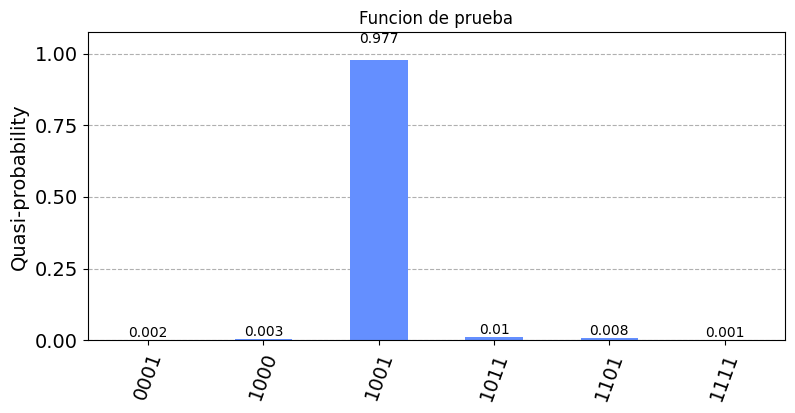

In [9]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
shots = 1024

qc = generate_qaoa_circuit(theta_res.x)
counts = backend.run(qc, shots=shots).result().get_counts()
#plot_histogram(normalized_counts, figsize=(13, 6.83),
#               filename="../../latex/img/primer_grafo/sin_restriccion_extra/primer_paper_aer_resultado.png")
normalized_counts = {key: val / shots for (key, val) in counts.items()}

plot_histogram(normalized_counts, figsize=(9, 4), title=GRAPH_NAME)

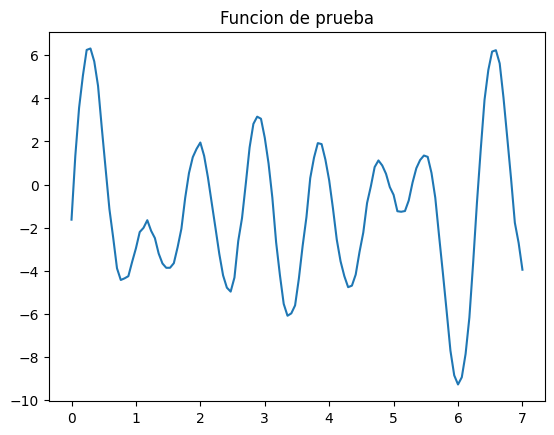

In [11]:
# Gamma function
import numpy as np
import matplotlib.pyplot as plt

def gamma_function(title=""):
    x = np.linspace(0, 7, 120)
    y = []
    beta = 1.0
    for gamma in x:
        y.append(execute_circuit([beta, gamma]))

    plt.title(title)
    plt.plot(x, y)
    # plt.savefig("../../latex/img/primer_grafo/sin_restriccion_extra/primer-paper-mod_originales-gamma_fun.png")
    plt.show()


gamma_function(GRAPH_NAME)

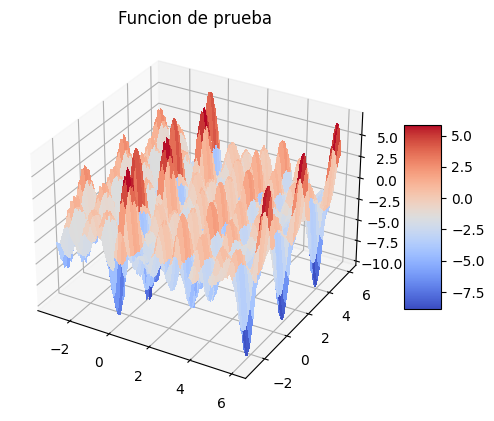

In [42]:
# 3D Gamma function
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools

def gamma_function_3d(title=""):
    beta = np.linspace(-3, 6, 120)
    gamma = np.linspace(-3, 6, 120)
    z = np.zeros([len(gamma), len(beta)])
    beta, gamma = np.meshgrid(beta, gamma)

    for i in range(z.shape[0]):
        for j in range(z.shape[1]):
            z[i][j] = execute_circuit([beta[i][j], gamma[i][j]])

    fig = plt.figure()
    axis = plt.axes(projection='3d')
    plt.title(title)
    figure = axis.plot_surface(gamma, beta, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    fig.colorbar(figure, shrink=0.5, aspect=5)
    # plt.savefig("../../latex/img/primer_grafo/sin_restriccion_extra/primer_paper_p_27_gamma_fun.png")
    plt.show()


gamma_function_3d(GRAPH_NAME)

In [43]:
# Statistics
def max_global_statistics(num_layers=1,
                          num_generations=100) -> Tuple[Dict[str, float],
                                                        Dict[str, float]]:
    max_statistics = {}
    global_statistics = {}
    for iteration in range(0, num_generations):
        theta_res = minimize(execute_circuit, [1.0, 1.0] * num_layers, method = "COBYLA")
        qc = generate_qaoa_circuit(theta_res.x)
        counts = backend.run(qc, shots=shots).result().get_counts()

        # Max statistics
        max_path = max(counts, key=counts.get)
        if max_path not in max_statistics:
            max_statistics[max_path] = 0
        max_statistics[max_path] += 1

        # Global statistics
        for (path, num_appearances) in counts.items():
            if path not in global_statistics:
                global_statistics[path] = 0
            global_statistics[path] += num_appearances

    for path in global_statistics:
        global_statistics[path] = global_statistics[path] / shots / num_generations  # Normalize

    for path in max_statistics:
        max_statistics[path] = max_statistics[path] / num_generations  # Normalize

    max_statistics = sorted(max_statistics.items(), key=lambda x: x[1], reverse=True)
    global_statistics = sorted(global_statistics.items(), key=lambda x: x[1], reverse=True)
    return max_statistics, global_statistics


print(GRAPH_NAME + ":\n")
interval_num_layers = (1, 6)
for p in range(interval_num_layers[0], interval_num_layers[1] + 1):
    max_st, global_st = max_global_statistics(num_layers=p, num_generations=100)
    print(f"Max statistics (p = {p}): ", str(max_st))
    print(f"Global statistics (p = {p}): ", str(global_st))
    print()

Funcion de prueba:



Max statistics (p = 1):  [('1011', 0.78), ('0011', 0.22)]
Global statistics (p = 1):  [('1011', 0.285673828125), ('0011', 0.239326171875), ('1010', 0.091689453125), ('0010', 0.072109375), ('1001', 0.068466796875), ('0001', 0.057841796875), ('1111', 0.045400390625), ('0111', 0.0423046875), ('1000', 0.02568359375), ('0000', 0.0191015625), ('1110', 0.01337890625), ('1101', 0.0112109375), ('0110', 0.0112109375), ('0101', 0.009521484375), ('1100', 0.00404296875), ('0100', 0.003037109375)]



Max statistics (p = 2):  [('1001', 1.0)]
Global statistics (p = 2):  [('1001', 0.888203125), ('1011', 0.047470703125), ('0001', 0.02193359375), ('1000', 0.019306640625), ('1101', 0.016865234375), ('0011', 0.002431640625), ('1010', 0.0015625), ('0000', 0.00068359375), ('0101', 0.000576171875), ('1111', 0.000498046875), ('1100', 0.0003125), ('0010', 9.765625e-05), ('0100', 3.90625e-05), ('0111', 1.953125e-05)]



Max statistics (p = 3):  [('1001', 0.58), ('1011', 0.42)]
Global statistics (p = 3):  [('1001', 0.456396484375), ('1011', 0.34166015625), ('0011', 0.080185546875), ('0001', 0.051455078125), ('1000', 0.017138671875), ('1010', 0.01583984375), ('1111', 0.012119140625), ('1101', 0.010751953125), ('0010', 0.0045703125), ('0111', 0.00376953125), ('0000', 0.00263671875), ('0101', 0.0019921875), ('1110', 0.000546875), ('1100', 0.000439453125), ('0110', 0.0003515625), ('0100', 0.000146484375)]



Max statistics (p = 4):  [('1001', 0.97), ('1011', 0.03)]
Global statistics (p = 4):  [('1001', 0.72263671875), ('1011', 0.1873046875), ('1101', 0.0365625), ('0001', 0.01755859375), ('1000', 0.01228515625), ('1111', 0.0106640625), ('0011', 0.0072265625), ('1010', 0.003056640625), ('0101', 0.000859375), ('1100', 0.000654296875), ('0111', 0.000478515625), ('0000', 0.000361328125), ('0010', 0.000185546875), ('1110', 0.000146484375), ('0100', 1.953125e-05)]



Max statistics (p = 5):  [('1001', 0.53), ('1011', 0.47)]
Global statistics (p = 5):  [('1001', 0.466650390625), ('1011', 0.409921875), ('0011', 0.03390625), ('1101', 0.026103515625), ('1111', 0.02203125), ('0001', 0.018486328125), ('1010', 0.01037109375), ('1000', 0.0074609375), ('0111', 0.00142578125), ('0010', 0.001328125), ('0101', 0.000888671875), ('0000', 0.0005078125), ('1110', 0.000478515625), ('1100', 0.00041015625), ('0110', 1.953125e-05), ('0100', 9.765625e-06)]



Max statistics (p = 6):  [('1001', 0.93), ('1011', 0.07)]
Global statistics (p = 6):  [('1001', 0.52900390625), ('1011', 0.331474609375), ('0001', 0.058046875), ('0011', 0.0358203125), ('1101', 0.021533203125), ('1111', 0.0128125), ('1000', 0.004111328125), ('0101', 0.002431640625), ('1010', 0.00236328125), ('0111', 0.001259765625), ('0000', 0.00046875), ('0010', 0.0002734375), ('1100', 0.00021484375), ('1110', 0.00015625), ('0110', 2.9296875e-05)]



In [ ]:
# Best result
def get_best_result(optimal_solution: str,
                    num_layers=1, num_generations=100) -> Dict[str, int]:
    max_prob = 0
    res = {}
    for iteration in range(0, num_generations):
        theta_res = minimize(execute_circuit, [1.0, 1.0] * num_layers, method = "COBYLA")
        qc = generate_qaoa_circuit(theta_res.x)
        counts = backend.run(qc, shots=shots).result().get_counts()

        if OPTIMAL_SOLUTION in counts and counts[OPTIMAL_SOLUTION] > max_prob:
            res = counts

    for path in res:
        res[path] = res[path] / shots  # Normalize

    res = {k: v for k, v in sorted(res.items(), key=lambda x: x[1], reverse=True)}
    return res

interval_num_layers = (1, 3)
for p in range(interval_num_layers[0], interval_num_layers[1] + 1):
    best_result = get_best_result(OPTIMAL_SOLUTION, num_layers=p, num_generations=100)
    print(f"Best result (p = {p}): ", best_result)

In [ ]:
# Save an IBM Quantum account on disk
from qiskit_ibm_runtime import QiskitRuntimeService

#QiskitRuntimeService.save_account(
#    channel="ibm_quantum",
#    token="",
#    overwrite=True
#)
QiskitRuntimeService.active_account(QiskitRuntimeService(channel="ibm_quantum"))

In [ ]:
# Print all available computers and the number of current jobs in each one
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")

# Get only valid backends
backends = [(b.name, b.status().pending_jobs, b.num_qubits)
            for b in service.backends(simulator=False, operational=True)]
backends = sorted(backends, key=lambda x: x[1])

header = "Quantum_computer pending_jobs nqubits"
print(header)
for back in backends:
    computer = '{:<{mx}}'.format(back[0], mx=len(header.split()[0]))
    pending_jobs = '{:<{mx}}'.format(back[1], mx=len(header.split()[1]))
    nqubits = back[2]
    print(f"{computer} {pending_jobs} {nqubits}")

In [ ]:
# Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session, Options
from scipy.optimize import minimize

service = QiskitRuntimeService(channel="ibm_quantum")
options = Options()
options.execution.shots = 512

def execute_circuit(theta):
    qc = generate_qaoa_circuit(theta)
    job = Sampler(options=options).run(qc)
    result = job.result()
    counts = result.quasi_dists[0].binary_probabilities(len(EDGES))
    return compute_expectation(counts)

quantum_computer = "ibm_lagos"
with Session(backend=service.backend(quantum_computer)):
    num_layers = 4
    theta_res = minimize(execute_circuit, [1.0, 1.0] * num_layers, method = "COBYLA")
    print(theta_res)
    f = open(f"{GRAPH_NAME.split()[0]}_{quantum_computer}_p-{num_layers}.txt", "w")
    f.write(theta_res)
    f.write("\n")
    f.close()

In [ ]:
#!dunstify -t $((30 * 60*1000)) --urgency=critical "Ejecución completada"
!dunstify -t $((12 * 60*60*1000)) --urgency=critical "Ejecución completada"